#### Cell segregation (Cellpose) from the 3D image of the zebrafish habenula. Localise the RNA signals (skimage.feature.blob_log) in the cells and identify co-localisation of two different RNA signals (tac3a and vglut1). Merge the segregation & RNA blob data and produce visualised result (napari view & 3D animation) to illustrate the localisation of RNA signal

In [1]:

import numpy as np
import os
from skimage.feature import blob_log, blob_dog, blob_doh
import skimage
import matplotlib as mpl
import matplotlib.pyplot as plt
from czifile import CziFile
import pandas as pd
from cellpose import utils, io, models #, core, metrics, plot
import napari
from napari_animation import Animation
from napari_animation.easing import Easing


In [6]:
# open the image from the local path
dir = "_local directory_"
path = os.path.join(dir, "_file name_")


---
## 1. image loading & preprocessing

#### a) If the format of the image is _.tiff_

In [ ]:
im = io.imread(path)

In [ ]:
im.shape

In [9]:
im_Mg = im[:,2]
im_Gr = im[:,0]
im_cell = im[:,1]

#### b) If the format of the image is _.CZI_

In [5]:
im = CziFile(path)
im_array = im.asarray()

In [6]:
im.shape

(1, 3, 257, 2084, 3736, 1)

In [7]:
im_Mg = np.squeeze(im_array[0,0])
im_Gr = np.squeeze(im_array[0,1])
im_cell = np.squeeze(im_array[0,2])

In [8]:
im_Gr.shape

(257, 2084, 3736)

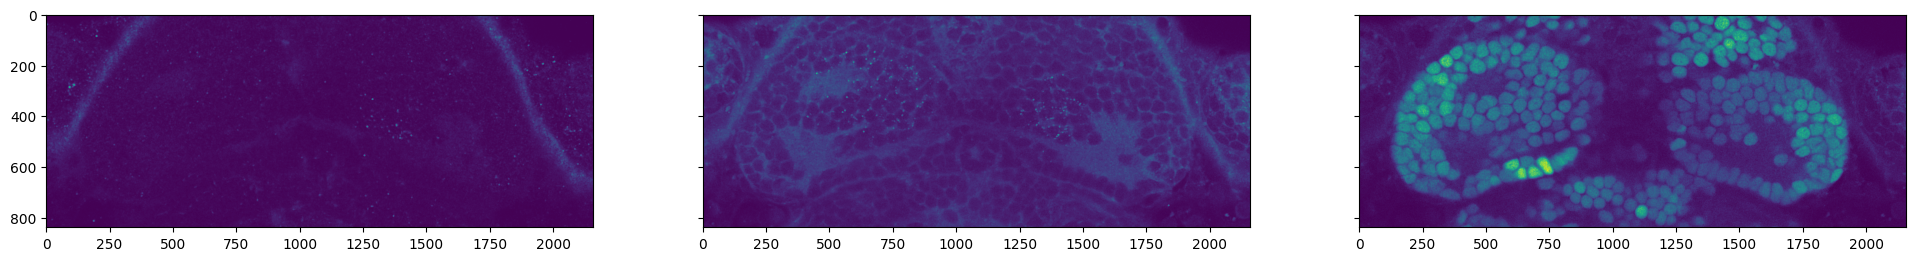

In [10]:
# check if the image is correctly loaded by showing a random frame
fig, ax = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
ax[0].imshow(im_Mg[120])
ax[1].imshow(im_Gr[120])
ax[2].imshow(im_cell[120])

#### c) image processing

In [10]:
#enhancing the contrast of the image, will generate a better result in cell segregation
im_c = im_cell
im_C = skimage.exposure.equalize_adapthist(im_c,kernel_size=15,clip_limit=0.007,nbins=300)

im_g = im_Gr
im_G = skimage.exposure.equalize_adapthist(im_g,kernel_size=15,clip_limit=0.007,nbins=300)

im_m = im_Mg
im_M = skimage.exposure.equalize_adapthist(im_m,kernel_size=15,clip_limit=0.007,nbins=300)

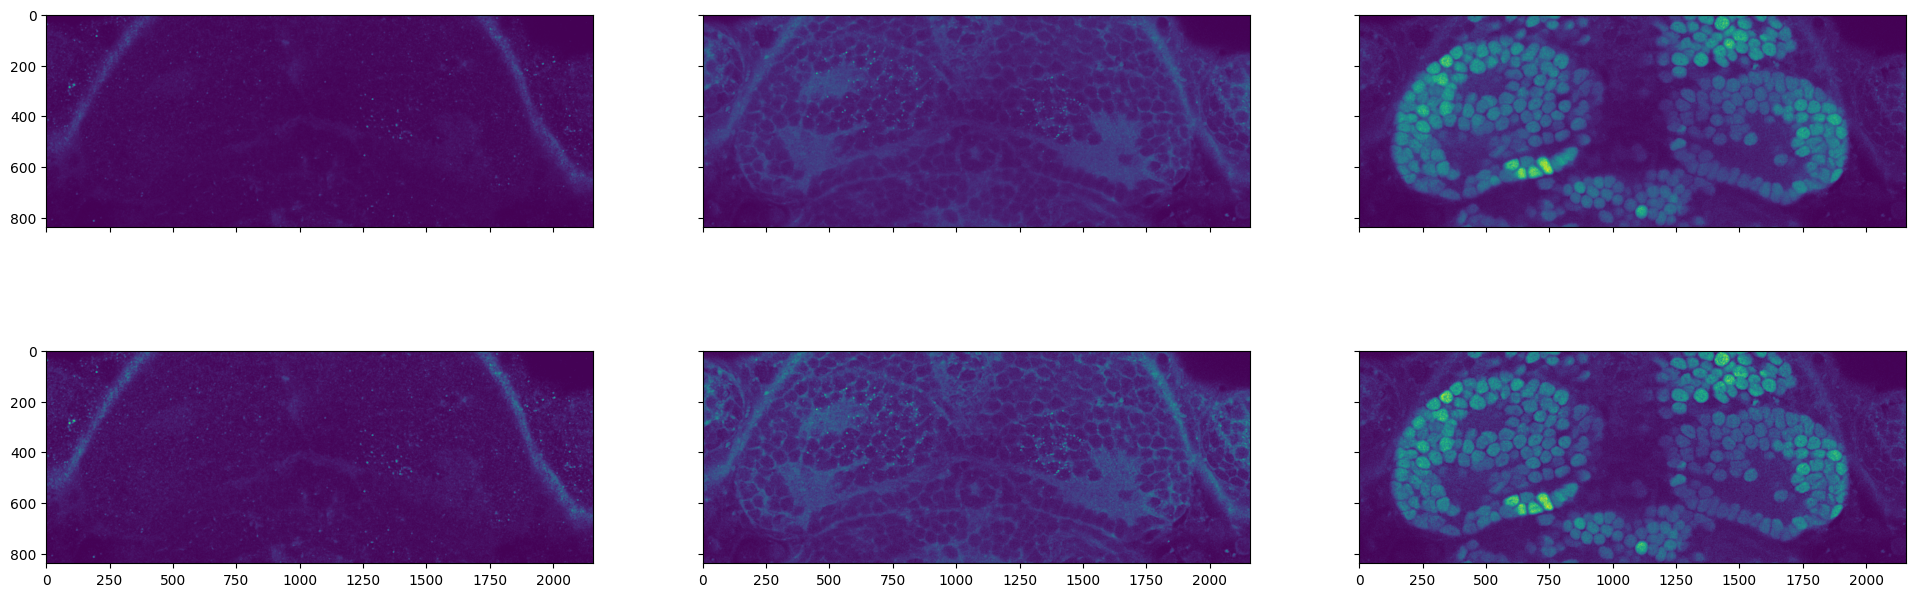

In [19]:
# compare the contrast of images 
fig, ax = plt.subplots(2, 3, figsize=(24, 8), sharex=True, sharey=True)
ax[0,0].imshow(im_Mg[120])
ax[0,1].imshow(im_Gr[120])
ax[0,2].imshow(im_cell[120])
ax[1,0].imshow(im_M[120])
ax[1,1].imshow(im_G[120])
ax[1,2].imshow(im_C[120])

---
## cell segmentation

In [14]:
# use a trained model saved in local directory
model_path = "_local path to the model_"


In [ ]:
# set parameters
diameter = 0 # cell diameter
flow_threshold = 0.4 # the maximum allowed error of the flows for each mask
cellprob_threshold= 0 # Decrease this threshold if cellpose is not returning as many ROIs as you’d expect

In [16]:
# declare model
model = models.CellposeModel(pretrained_model=model_path)

In [17]:
# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

In [28]:
# run model on test images
masks, flows, styles = model.eval(im_C,
                                  channels=[0, 0], 
                                  diameter=diameter, 
                                  flow_threshold=flow_threshold,
                                  #anisotropy=2.5, 
                                  stitch_threshold = 0.5, #suggest [0.1,0.5]
                                  #do_3D = True, 
                                  cellprob_threshold=cellprob_threshold
                                  )

In [21]:
masks_ = masks.copy()
# remove small segregations with sizes < 'min_size'
masks_filtered = utils.fill_holes_and_remove_small_masks(masks_, min_size=100) 

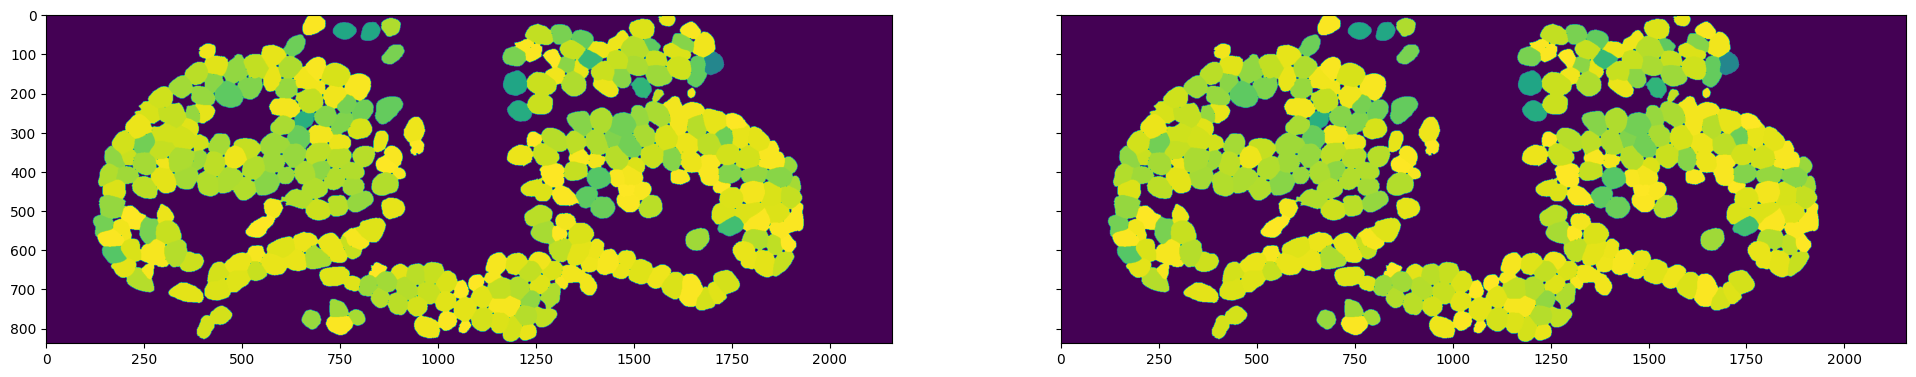

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8), sharex=True, sharey=True)
ax[0].imshow(masks[120])
ax[1].imshow(masks_filtered[120])

In [29]:
# saving segregation result (save masks only)
np.save(dir + '/Data/mask_0.5', masks)

---

## Blob detection

In [ ]:
# detect RNA signals as blobs of Laplacian of Gaussian from the two RNA signal channels
blobs_log_G = blob_log(im_G, min_sigma=2, max_sigma=20, num_sigma=9, threshold=0.048)
blobs_log_M = blob_log(im_M, min_sigma=2, max_sigma=20, num_sigma=9, threshold=0.052)

In [ ]:
# distribution of the sizes of blobs
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(blobs_log_G[:,-1],density=True)
ax[1].hist(blobs_log_M[:,-1],density=True)

In [ ]:
# filter out big blobs which are likely to be the integration of multiple signals

blobs_log_filt_G = blobs_log_G[blobs_log_G[:,-1] <8]
blobs_log_filt_M = blobs_log_M[blobs_log_M[:,-1] <8]

print(blobs_log_filt_G.shape)
print(blobs_log_filt_M.shape)


In [ ]:
# save blob data

np.save(dir + '/Data/tac3a_R', blobs_log_filt_G)
np.save(dir + '/Data/vglut1_L', blobs_log_filt_M)

---
# Co-localization

#### load blob & cell segregation from local file

In [ ]:
# load blobs / from local path
spots_T = blobs_log_filt_G #np.load(os.path.join(dir, 'Data/S150_Tac3a_R.npy'), allow_pickle=True)
spots_V = blobs_log_filt_M #np.load(os.path.join(dir, 'Data/S150_vglut1_L.npy'), allow_pickle=True)

# load cell segregation / from local path
cells = masks_filtered #np.load(os.path.join(dir, "Data/multichannel_cells.npy"), allow_pickle=True)

In [7]:
# set the midline of the image, roughly separate the brain into left & right hemisphere
midline = cells.shape[2]/2

In [9]:
# for each Tac3a signals, find the number of the cell they are located in
cell_num = []
for i in range(spots_T.shape[0]):
    z = int(spots_T[i][-4])
    y = int(spots_T[i][-3])
    x = int(spots_T[i][-2])
    cell_num.append([cells[z][y][x]])
spots_t = np.append(spots_T, cell_num, axis = 1)

In [10]:
# for each vglut1 signals, find the number of the cell they are located in
cell_num = []
for i in range(spots_V.shape[0]):
    z = int(spots_V[i][-4])
    y = int(spots_V[i][-3])
    x = int(spots_V[i][-2])
    cell_num.append([cells[z][y][x]])
spots_v = np.append(spots_V, cell_num, axis = 1)

In [11]:
# converting the np array into pd DataFrame
spots_t_pd = pd.DataFrame({'cell ID': spots_t[:,-1], 'radius': spots_t[:,-2], 'z-coordinate': spots_t[:,-5], 'y-coordinate': spots_t[:,-4], 'x-coordinate': spots_t[:,-3]}) 
spots_v_pd = pd.DataFrame({'cell ID': spots_v[:,-1], 'radius': spots_v[:,-2], 'z-coordinate': spots_v[:,-5], 'y-coordinate': spots_v[:,-4], 'x-coordinate': spots_v[:,-3]}) 


In [12]:
# count the number of blobs of each RNA signal in each cell
spots_t_pd['freq'] = spots_t_pd.groupby('cell ID')['cell ID'].transform('count')
spots_v_pd['freq'] = spots_v_pd.groupby('cell ID')['cell ID'].transform('count')

In [13]:
# determine if a blob is located in left/right hemisphere
spots_t_pd.loc[spots_t_pd['x-coordinate'] < midline, 'LR'] = 'L'
spots_t_pd.loc[spots_t_pd['x-coordinate'] >= midline, 'LR'] = 'R'
spots_v_pd.loc[spots_v_pd['x-coordinate'] < midline, 'LR'] = 'L'
spots_v_pd.loc[spots_v_pd['x-coordinate'] >= midline, 'LR'] = 'R'

In [14]:
# identify all the cells that have RNA signal and create a DataFrame for them
count = pd.DataFrame({'cell ID': pd.unique(np.concatenate((spots_t_pd['cell ID'], spots_v_pd['cell ID']), axis = None))})

In [15]:

for id in count['cell ID'].values:
    if id in spots_t_pd['cell ID'].values:
        # identfity if the cell is located in left/right hemisphere
        count.loc[count['cell ID'] == id, 'LR'] = spots_t_pd.loc[spots_t_pd['cell ID'] == id].iat[0, -1]
        # how many tac3a signals are in the cell
        count.loc[count['cell ID'] == id, 'tac3a'] = spots_t_pd.loc[spots_t_pd['cell ID'] == id].iat[0, -2]
for id in count['cell ID'].values:
    if id in spots_v_pd['cell ID'].values:
        count.loc[count['cell ID'] == id, 'vglut1'] = spots_v_pd.loc[spots_v_pd['cell ID'] == id].iat[0, -2]
        count.loc[count['cell ID'] == id, 'LR'] = spots_v_pd.loc[spots_v_pd['cell ID'] == id].iat[0, -1]

In [16]:
# determine if a cell has co-localization of both signals
count['co-localization'] = np.logical_and(count['tac3a'] > 0, count['vglut1'] > 0)


In [17]:
# update if a blob is co-localized in another RNA signal in the same cell
for id in count['cell ID'].values:
    if id in spots_t_pd['cell ID'].values:
        spots_t_pd.loc[spots_t_pd['cell ID'] == id, 'co-localization'] = count.loc[count['cell ID'] == id].iat[0,-1]
for id in count['cell ID'].values:
    if id in spots_v_pd['cell ID'].values:
        spots_v_pd.loc[spots_v_pd['cell ID'] == id, 'co-localization'] = count.loc[count['cell ID'] == id].iat[0,-1]

---
### plotting - check which points are missing
plot the points that have been assigned to a cell - ideally colourmapped with cell id

plot2 the points that are missing - see if they are truely noise

In [20]:
tac3a_l = spots_t_pd[spots_t_pd['cell ID'] != 0][spots_t_pd['LR'] == 'L'].to_numpy()
tac3a_r = spots_t_pd[spots_t_pd['cell ID'] != 0][spots_t_pd['LR'] == 'R'].to_numpy()

vglut1_l = spots_v_pd[spots_v_pd['cell ID'] != 0][spots_v_pd['LR'] == 'L'].to_numpy()
vglut1_r = spots_v_pd[spots_v_pd['cell ID'] != 0][spots_v_pd['LR'] == 'R'].to_numpy()

tac3a_s = spots_t_pd[spots_t_pd['cell ID'] != 0][spots_t_pd['co-localization']].to_numpy()
vglut1_s = spots_v_pd[spots_v_pd['cell ID'] != 0][spots_v_pd['co-localization']].to_numpy()
coloc = np.concatenate((tac3a_s, vglut1_s))


tac3a_n = spots_t_pd[spots_t_pd['cell ID'] == "0.0"].to_numpy()
vglut1_n = spots_v_pd[spots_v_pd['cell ID'] == 0].to_numpy()

/var/folders/dx/kxfk7b2x0llbf12kq2hrpzk40000gn/T/ipykernel_17860/390831937.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tac3a_l = spots_t_pd[spots_t_pd['cell ID'] != 0][spots_t_pd['LR'] == 'L'].to_numpy()
/var/folders/dx/kxfk7b2x0llbf12kq2hrpzk40000gn/T/ipykernel_17860/390831937.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tac3a_r = spots_t_pd[spots_t_pd['cell ID'] != 0][spots_t_pd['LR'] == 'R'].to_numpy()
/var/folders/dx/kxfk7b2x0llbf12kq2hrpzk40000gn/T/ipykernel_17860/390831937.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vglut1_l = spots_v_pd[spots_v_pd['cell ID'] != 0][spots_v_pd['LR'] == 'L'].to_numpy()
/var/folders/dx/kxfk7b2x0llbf12kq2hrpzk40000gn/T/ipykernel_17860/390831937.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vglut1_r = spots_v_pd[spots_v_pd['cell ID'] != 0][spots_v_pd['LR'] == 'R'].to_numpy()


In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(36, 16), sharex=True, sharey=True)

#ax[0][0].imshow(im_c,vmin=10,vmax=1000,cmap='gray')
ax[0][0].imshow(cells)
ax[0][0].imshow(im_G,vmin=0.02,vmax=0.5,cmap='hot',alpha=0.5)
ax[0][1].imshow(im_c,vmin=10,vmax=1200,cmap='gray')

for idex, blob in enumerate(tac3a_s):
        id = int(blob[0])
        x = blob[1]
        y = blob[2]
        r = blob[3]
        c = plt.Circle((x, y), r, color=rgba_g[id], linewidth=2, fill=False)
        ax[0][1].add_patch(c)

ax[0][2].imshow(cells)
for idex, blob in enumerate(tac3a_n):
        x = blob[1]
        y = blob[2]
        r = blob[3]
        c = plt.Circle((x, y), r, color=rgba_g[idex], linewidth=2, fill=False)
        ax[0][2].add_patch(c)  
        
#ax[1][0].imshow(im_c,vmin=10,vmax=1000,cmap='gray')
ax[1][0].imshow(cells)
ax[1][0].imshow(im_M,vmin=0.02,vmax=0.5,cmap='hot',alpha=0.5)
ax[1][1].imshow(im_c,vmin=10,vmax=1200,cmap='gray')
for idex, blob in enumerate(vglut1_s):
        id = int(blob[0])
        x = blob[1]
        y = blob[2]
        r = blob[3]
        c = plt.Circle((x, y), r, color=rgba_g[id], linewidth=2, fill=False)
        ax[1][1].add_patch(c)       

ax[1][2].imshow(cells)
for idex, blob in enumerate(vglut1_n):
        x = blob[1]
        y = blob[2]
        r = blob[3]
        c = plt.Circle((x, y), r, color=rgba_g[idex], linewidth=2, fill=False)
        ax[1][2].add_patch(c)        
plt.show()

---
## napari-view

In [23]:
viewer = napari.Viewer()

In [24]:
viewer.camera.center = (300.0, 333.5, 827.0)

In [31]:
# add background image 
viewer.add_image(
                 im_C,
                 scale = [3, 1, 1]
                 )

<Image layer 'im_C' at 0x188b02490>

In [26]:
cells_layer = viewer.add_labels(
                 masks_filtered,
                 num_colors = 1024,
                 #color = 'white',
                 opacity=0.25,
                 scale = [3, 1, 1]
                 )

tac3a_l_layer = viewer.add_points(
                 tac3a_l[:,2:5].astype('float64'),
                 name = 'tac3a_l',
                 size = tac3a_l[:,1].astype('float64'),
                 face_color = 'blueviolet',
                 #edge_color = 'coral',
                 blending = 'translucent_no_depth',
                 scale = [2, 1, 1]
                 )
tac3a_r_layer = viewer.add_points(
                 tac3a_r[:,2:5].astype('float64'),
                 name = 'tac3a_r',
                 size = tac3a_r[:,1].astype('float64'),
                 face_color = 'blueviolet',
                 #edge_color = 'coral',
                 blending = 'translucent_no_depth',
                 scale = [2, 1, 1]
                 )
vglut1_l_layer = viewer.add_points(
                 vglut1_l[:,2:5].astype('float64'),
                 name = 'vglut1_l',
                 size = vglut1_l[:,1].astype('float64'),
                 face_color = 'aquamarine',
                 #edge_color = 'aquamarine',
                 blending = 'translucent_no_depth',
                 scale = [2, 1, 1]
                 )
vglut1_r_layer = viewer.add_points(
                 vglut1_r[:,2:5].astype('float64'),
                 name = 'vglut1_r',
                 size = vglut1_r[:,1].astype('float64'),
                 face_color = 'aquamarine',
                 #edge_color = 'aquamarine',
                 blending = 'translucent_no_depth',
                 scale = [2, 1, 1]
                 )
coloc_layer = viewer.add_points(
                 coloc[:,2:5].astype('float64'),
                 name = 'coloc',
                 size = coloc[:,1].astype('float64'),
                 face_color = 'blueviolet',
                 edge_color = 'blueviolet',
                 symbol = 'ring',
                 blending = 'translucent_no_depth',
                 scale = [2, 1, 1],
                 )


In [25]:
cell_t = np.copy(cells)
mask_t = ~np.isin(cell_t, spots_t_pd['cell ID'].values)
cell_t[mask_t] = 0

cell_v = np.copy(cells)
mask_v = ~np.isin(cell_v, spots_v_pd['cell ID'].values)
cell_v[mask_v] = 0

cell_co = np.copy(cells)
cell_co[mask_t] = 0
cell_co[mask_v] = 0


cells_layer = viewer.add_labels(
                 cells,
                 num_colors = 1024,
                 #color = 'white',
                 opacity=0.25,
                 scale = [2, 1, 1]
                 )
cells_t_layer = viewer.add_labels(
                 cell_t,
                 num_colors = 1024,
                 #color = {'a':'yellow'},
                 opacity=0.25,
                 scale = [2, 1, 1]
                 )
cells_v_layer = viewer.add_labels(
                 cell_v,
                 num_colors = 1024,
                 opacity=0.25,
                 scale = [2, 1, 1]
                 )
cells_co_layer = viewer.add_labels(
                 cell_co,
                 num_colors = 1024,
                 opacity=0.25,
                 scale = [2, 1, 1]
                 )

---
## 3D Animation

In [27]:
animation = Animation(viewer)
viewer.update_console({'animation': animation})

viewer.dims.ndisplay = 3

cells_t_layer.visible = False
cells_v_layer.visible = False
cells_co_layer.visible = False
cells_layer.visible = False

coloc_layer.visible = False
tac3a_r_layer.visible = True
tac3a_l_layer.visible = True
vglut1_r_layer.visible = True
vglut1_l_layer.visible = True
viewer.camera.center = (300.0, 333.5, 827.0)
viewer.camera.angles = (0.0, 0.0, 90.0)
viewer.camera.zoom = 3
animation.capture_keyframe()


viewer.camera.angles = (0.0, 0.0, -5.0)
viewer.camera.zoom = 0.7
animation.capture_keyframe(steps=25, ease = Easing.CIRCULAR)


viewer.camera.angles = (0.0, 5.0, -5.0)
animation.capture_keyframe(steps=5)

cells_layer.visible = True
viewer.camera.angles = (0.0, 90.0, -5.0)
animation.capture_keyframe(steps=85)

viewer.camera.angles = (0.0, 180.0, -5.0)
animation.capture_keyframe(steps=90)


viewer.camera.angles = (0.0, 0.0, -85.0)
animation.capture_keyframe(steps=25, ease = Easing.CIRCULAR)

cells_t_layer.visible = True
animation.capture_keyframe(steps=5)

cells_t_layer.visible = False
animation.capture_keyframe(steps=5)

cells_t_layer.visible = True
animation.capture_keyframe(steps=5)

cells_t_layer.visible = False
animation.capture_keyframe(steps=5)

cells_t_layer.visible = True
animation.capture_keyframe(steps=10)


viewer.camera.center = (300.0, 370, 400.0)
viewer.camera.angles = (0.0, 0.0, 0.0)
viewer.camera.zoom = 2.2
animation.capture_keyframe(steps=20, ease = Easing.CIRCULAR)


viewer.camera.angles = (0.0, -20.0, -90.0)
animation.capture_keyframe(steps=90)

viewer.camera.center = (300.0, 333.5, 827.0)
viewer.camera.zoom = 0.7
animation.capture_keyframe(steps=20, ease = Easing.CIRCULAR)

viewer.camera.center = (300.0, 350, 1200.0)
viewer.camera.angles = (0.0, 0.0, 0.0)
viewer.camera.zoom = 2.2
animation.capture_keyframe(steps=20, ease = Easing.CIRCULAR)

viewer.camera.angles = (0.0, 20.0, -90.0)
animation.capture_keyframe(steps=90)


viewer.camera.angles = (0.0, 0.0, -5.0)
viewer.camera.zoom = 0.8
viewer.camera.center = (300.0, 333.5, 827.0)
animation.capture_keyframe(steps=20, ease = Easing.CIRCULAR)




#animation.capture_keyframe(steps=10, ease = Easing.CIRCULAR)

coloc_layer.visible = True
animation.capture_keyframe(steps=25, ease = Easing.CIRCULAR)
animation.animate('co-localization.mov', canvas_only=True)


Rendering frames...


100%|██████████| 546/546 [58:17<00:00,  6.41s/it]
